# Decision Tree Algorithm

## Overview

The Decision Tree algorithm is a versatile machine learning model that can perform both classification and regression tasks. It uses a tree-like structure where internal nodes represent a feature (or attribute), branches represent decision rules, and each leaf node represents the outcome. The Decision Tree splits the data into subsets based on the most significant feature, making it easy to interpret.

### How Decision Tree Works

1. **Training Phase**:
   - The algorithm begins at the root node and splits the data based on the feature that results in the maximum reduction in impurity (e.g., Gini impurity, entropy).
   - The process is repeated recursively for each child node until a stopping criterion is met (e.g., maximum depth, minimum number of samples per leaf).

2. **Prediction Phase**:
   - For a given test data point, the algorithm starts at the root node and traverses down the tree according to the decision rules until it reaches a leaf node. The value of the leaf node is the predicted class.

### Key Points

- Decision Trees are easy to interpret and visualize, making them useful for understanding the relationships in data.
- They can handle both numerical and categorical data and require little data preprocessing.
- However, they can easily overfit the training data if not pruned or regularized properly. Techniques such as pruning, setting a maximum depth, or using ensemble methods (e.g., Random Forests) can help mitigate overfitting.

### Implementation Objective

In this notebook, we will implement the Decision Tree algorithm from scratch using Python. We will test our implementation on a dataset and evaluate its performance using metrics such as confusion matrix, accuracy, recall, precision, and F1-score.


### Importing necessary libraries

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

### Decision Tree Node implementation


In [21]:
class DecisionTreeNode:
    def __init__(self, gini, num_samples, num_samples_per_class, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_idx = 0
        self.threshold = 0
        self.left = None
        self.right = None

### Decision Tree Implementation

In [22]:
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, criterion='gini', min_samples_leaf=1):
        """
        Initialize the Decision Tree model.

        Parameters:
        - max_depth: Maximum depth of the tree.
        - min_samples_split: Minimum number of samples required to split an internal node.
        - criterion: The function to measure the quality of a split ('gini' or 'entropy').
        - min_samples_leaf: Minimum number of samples required to be at a leaf node.
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.min_samples_leaf = min_samples_leaf

    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _gini(self, y):
        m = len(y)
        if m == 0:
            return 0
        _, counts = np.unique(y, return_counts=True)
        p = counts / m
        return 1 - np.sum(p ** 2)

    def _entropy(self, y):
        m = len(y)
        if m == 0:
            return 0
        _, counts = np.unique(y, return_counts=True)
        p = counts / m
        return -np.sum(p * np.log2(p))

    def _calculate_criterion(self, y):
        if self.criterion == 'gini':
            return self._gini(y)
        elif self.criterion == 'entropy':
            return self._entropy(y)
        else:
            raise ValueError(f"Unsupported criterion: {self.criterion}")

    def _best_split(self, X, y):
        m, n = X.shape
        if m <= 1 or len(np.unique(y)) == 1:
            return None, None

        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]
        best_gini = self._calculate_criterion(y)
        best_idx, best_thr = None, None

        for idx in range(self.n_features_):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                if i < self.min_samples_leaf or (m - i) < self.min_samples_leaf:
                    continue
                gini_left = self._calculate_criterion(num_left)
                gini_right = self._calculate_criterion(num_right)
                gini = (i * gini_left + (m - i) * gini_right) / m
                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2

        return best_idx, best_thr

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(num_samples_per_class)
        node = DecisionTreeNode(
            gini=self._gini(y),
            num_samples=len(y),
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
        )

        if depth < self.max_depth and len(y) >= self.min_samples_split:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] <= thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_idx = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def _predict(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_idx] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class


### Evaluation function for Decision Tree


In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_decision_tree(X_train, X_test, y_train, y_test, max_depth=None, min_samples_split=2, criterion='gini', min_samples_leaf=1):
    # Initialize and train the Decision Tree model
    tree = DecisionTree(max_depth=max_depth, min_samples_split=min_samples_split, criterion=criterion, min_samples_leaf=min_samples_leaf)
    tree.fit(X_train, y_train)

    # Predict on the test set
    predictions = tree.predict(X_test)

    # Calculate accuracy
    accuracy = np.sum(predictions == y_test) / len(y_test)
    print(f'Accuracy: {accuracy:.2f}')

    # Calculate precision, recall, and F1-score with zero_division=0 to handle undefined metrics
    precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
    recall = recall_score(y_test, predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_test, predictions, average='weighted', zero_division=0)

    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, predictions)
    classes = np.unique(y_test)

    # Plot normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix - Decision Tree")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Calculate ROC-AUC score for binary classification
    if len(classes) == 2:
        roc_auc = roc_auc_score(y_test, predictions)
        print(f'ROC AUC Score: {roc_auc:.2f}')

        # Plot ROC Curve
        fpr, tpr, _ = roc_curve(y_test, predictions)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
    else:
        print("ROC AUC Score and ROC Curve are not applicable for multiclass classification.")

### Load All Datasets


#### Iris Dataset


In [24]:
iris = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
iris.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
iris['class'] = iris['class'].astype('category').cat.codes
X_iris = iris.iloc[:, :-1].values
y_iris = iris.iloc[:, -1].values

#### Penguins Dataset


In [25]:
penguins = sns.load_dataset('penguins').dropna()
penguins['species'] = penguins['species'].astype('category').cat.codes
penguins['island'] = penguins['island'].astype('category').cat.codes
penguins['sex'] = penguins['sex'].astype('category').cat.codes
X_penguins = penguins.drop('species', axis=1).values
y_penguins = penguins['species'].values

#### Titanic Dataset


In [26]:
# Carregar conjunto de dados Titanic
titanic = sns.load_dataset('titanic')

# Preencher valores faltantes sem usar inplace=True
titanic['age'] = titanic['age'].fillna(titanic['age'].mean())
titanic['embarked'] = titanic['embarked'].fillna(titanic['embarked'].mode()[0])
titanic = titanic.dropna(subset=['embark_town', 'sex', 'fare', 'class'])

# Transformar características categóricas em numéricas
titanic['sex'] = titanic['sex'].astype('category').cat.codes
titanic['embarked'] = titanic['embarked'].astype('category').cat.codes
titanic['class'] = titanic['class'].astype('category').cat.codes

# Separar características e rótulos
X_titanic = titanic[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']].values
y_titanic = titanic['survived'].values

#### Census Income Dataset


In [27]:
census = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
census.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                  'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                  'hours-per-week', 'native-country', 'income']
for column in ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']:
    census[column] = census[column].astype('category').cat.codes
X_census = census.drop('income', axis=1).values
y_census = census['income'].values

### Test Naive Bayes on all datasets


Testing Decision Tree on Iris dataset with max_depth=3, min_samples_split=2, criterion=gini, min_samples_leaf=1
Accuracy: 0.37
Precision: 0.41
Recall: 0.37
F1 Score: 0.23


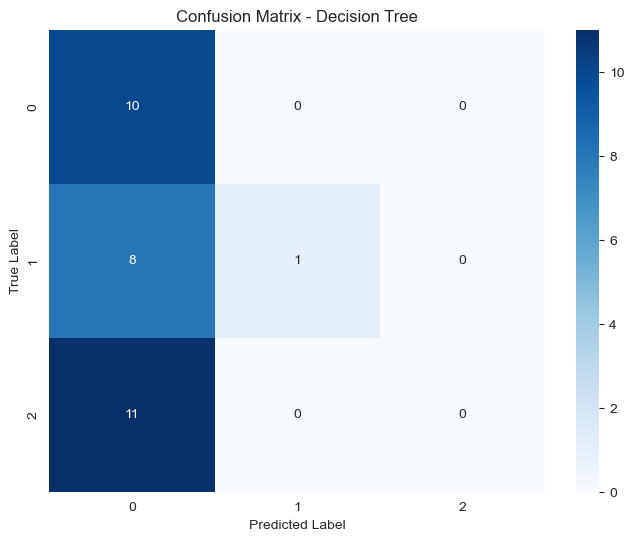

ROC AUC Score and ROC Curve are not applicable for multiclass classification.
Testing Decision Tree on Penguins dataset with max_depth=5, min_samples_split=4, criterion=entropy, min_samples_leaf=2
Accuracy: 0.64
Precision: 0.87
Recall: 0.64
F1 Score: 0.67


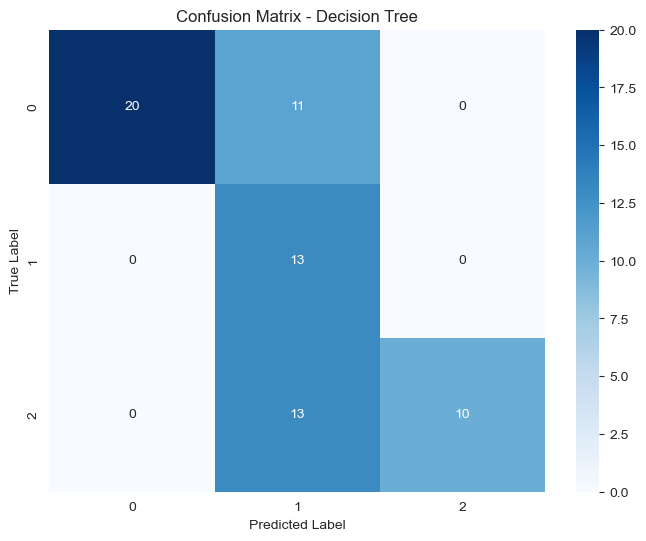

ROC AUC Score and ROC Curve are not applicable for multiclass classification.
Testing Decision Tree on Titanic dataset with max_depth=7, min_samples_split=10, criterion=entropy, min_samples_leaf=5
Accuracy: 0.61
Precision: 0.37
Recall: 0.61
F1 Score: 0.47


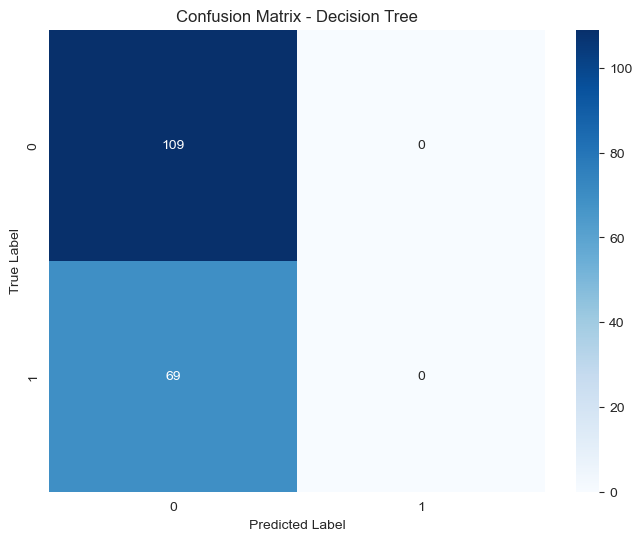

ROC AUC Score: 0.50


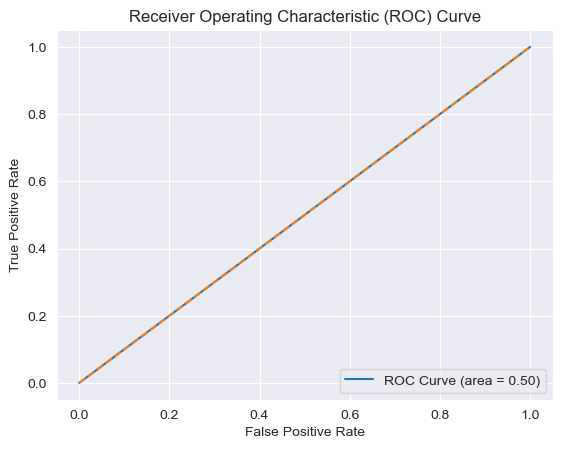

Testing Decision Tree on Census dataset with max_depth=10, min_samples_split=20, criterion=gini, min_samples_leaf=10
Accuracy: 0.76
Precision: 0.58
Recall: 0.76
F1 Score: 0.65


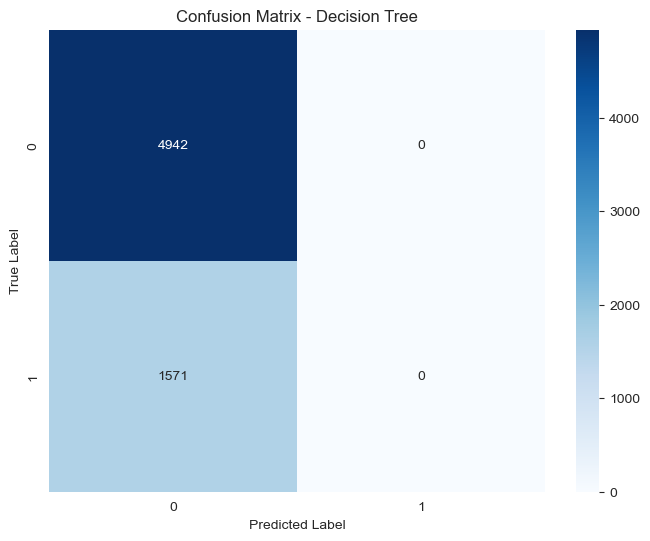

ROC AUC Score: 0.50


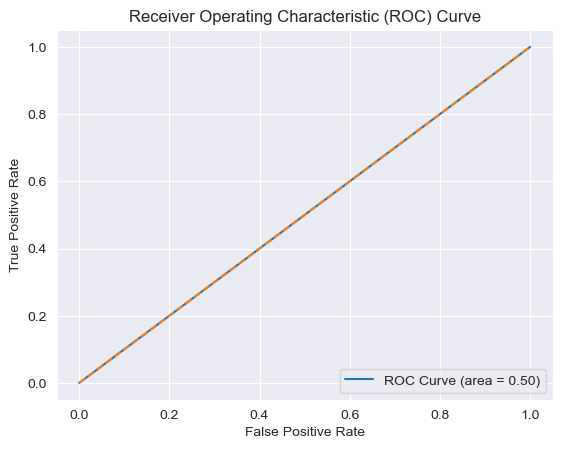

In [28]:
from sklearn.model_selection import train_test_split

datasets = {
    'Iris': {
        'data': (X_iris, y_iris),
        'max_depth': 3,  # The dataset is small and well-separated; a low depth prevents overfitting.
        'min_samples_split': 2,  # Minimum split since the dataset is small.
        'criterion': 'gini',  # Gini is simpler and works well with small, balanced data.
        'min_samples_leaf': 1  # Allows capturing all patterns, even if small.
    },
    'Penguins': {
        'data': (X_penguins, y_penguins),
        'max_depth': 5,  # Moderate depth to capture patterns in continuous features without overfitting.
        'min_samples_split': 4,  # Prevent overfitting by requiring a few samples per split.
        'criterion': 'entropy',  # Entropy provides more informative splits.
        'min_samples_leaf': 2  # Generalizes slightly, reducing overfitting.
    },
    'Titanic': {
        'data': (X_titanic, y_titanic),
        'max_depth': 7,  # Deeper tree to capture complex patterns in mixed feature types.
        'min_samples_split': 10,  # Reduces overfitting by requiring more samples for a split.
        'criterion': 'entropy',  # Entropy handles mixed binary and continuous features well.
        'min_samples_leaf': 5  # Provides regularization by requiring a few samples per leaf.
    },
    'Census': {
        'data': (X_census, y_census),
        'max_depth': 10,  # Deeper tree to handle the complexity of a large dataset.
        'min_samples_split': 20,  # Prevents overfitting by requiring more samples for each split.
        'criterion': 'gini',  # Gini is computationally efficient for large datasets.
        'min_samples_leaf': 10  # Ensures sufficient samples in each leaf to generalize better.
    }
}


for name, params in datasets.items():
    print(f"Testing Decision Tree on {name} dataset with max_depth={params['max_depth']}, min_samples_split={params['min_samples_split']}, criterion={params['criterion']}, min_samples_leaf={params['min_samples_leaf']}")
    
    # Extract data and parameters
    X, y = params['data']
    max_depth = params['max_depth']
    min_samples_split = params['min_samples_split']
    criterion = params['criterion']
    min_samples_leaf = params['min_samples_leaf']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Evaluate Decision Tree with the specific parameters for the current dataset
    evaluate_decision_tree(X_train, X_test, y_train, y_test, max_depth=max_depth, min_samples_split=min_samples_split, criterion=criterion, min_samples_leaf=min_samples_leaf)